## 6.0 Models

###  6.0.0 Data Modelling
We can use the two stage modeling approach and Pose Problem as
“classification and regression”     
1-  predict probability of returning of customer using all train set.The idea is
to classify non-zero transactions first and use that for better results for
revenues.data imbalance can be handled using under-sampling/ oversampling.    
2-  predict amount of transactions for those customers who returned.So, in
regression task train was filtered only by customers who had a session in 62-
day window.   

In [3]:
import pandas as pd
import json
import seaborn as sns#Plots
import matplotlib.pylab as plt
import numpy as np
from scipy import stats
from datetime import datetime, timedelta

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.linear_model import SGDClassifier,SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from scipy.stats import randint
from sklearn.svm import SVC,SVR 

In [4]:
#read pickle files
train1= pd.read_pickle('train1')
train2= pd.read_pickle('train2')
train3= pd.read_pickle('train3')
train4= pd.read_pickle('train4')
train5= pd.read_pickle('train5')

#concatenate all data
train_all = pd.concat([train1, train2, train3, train4, train5], axis=0, sort=False).reset_index(drop=True)

#totalTransactionRevenue_sum is same as revenue and can be dropped to avoid data leak
train_all= train_all.drop('totals.totalTransactionRevenue_sum',axis=1)

target_cols= ['returned','revenue','fullVisitorId']

train = train_all[train_all['revenue'].notnull()]
test  = train_all[train_all['revenue'].isnull()]

###  6.0.1 Create Classifier Data

In [5]:
#define target ,features for classifier
clf_features = train.drop(target_cols,axis=1)
clf_target = train['returned']

#check con=unts of target labels
clf_target.value_counts()

0.0    1347876
1.0       6976
Name: returned, dtype: int64

In [6]:
# Training and Testing Sets for classifier
train_features, test_features, train_labels, test_labels = train_test_split(clf_features, clf_target, 
                                                                            stratify=clf_target, 
                                                                            test_size = 0.25, random_state = 42)

In [7]:
train_labels.value_counts(),

(0.0    1010907
 1.0       5232
 Name: returned, dtype: int64,)

In [8]:
test_labels.value_counts()

0.0    336969
1.0      1744
Name: returned, dtype: int64

###  6.0.2 Create Regressor Data

In [9]:
#select data only fpr returned customers i.e returned =1 
reg_features = train.drop(target_cols,axis=1)[train['returned']==1]
#define target ,features for regressor
reg_target= train['revenue'][train['returned']==1]

###  6.0.3 Utility functions

In [10]:
# load test file
test_df= pd.read_csv("test_clean.csv",converters={"fullVisitorId": str},
                   usecols = ['fullVisitorId','totals.totalTransactionRevenue'] )

test_df['totals.totalTransactionRevenue'].fillna(0, inplace=True)           

def regr_metric(test_df,submit_df):
    ''' 
    Calculate & print regresion metrics
    '''
    test_grp= test_df.groupby('fullVisitorId')\
           ['totals.totalTransactionRevenue'].sum().apply(np.log1p,ais=1).reset_index()
    test_grp = pd.merge(test_grp,submit_df,on='fullVisitorId')
    rms= np.sqrt(metrics.mean_squared_error(test_grp['totals.totalTransactionRevenue'],
                                        test_grp['PredictedLogRevenue']))
    map = metrics.mean_absolute_error(test_grp['totals.totalTransactionRevenue'],test_grp['PredictedLogRevenue'])
    print('rms =',rms)
    print('map =',map)

def sub_file(y_true,y_pred):
    ''' 
    Submit file for kaggle
    '''
    submit_df=pd.DataFrame()
    submit_df['fullVisitorId']=y_true['fullVisitorId']
    submit_df['PredictedLogRevenue'] = y_pred
    return submit_df


##  6.1 Logistic + Linear regression

In [9]:
#Since Class labels are not balanced we use class_weight='balanced' in LogisticRegression.
logreg = LogisticRegression(class_weight='balanced', max_iter=1800,random_state=42)

In [10]:
%%time
logreg.fit(train_features, train_labels)

CPU times: user 19min 12s, sys: 4min 33s, total: 23min 45s
Wall time: 6min 11s


LogisticRegression(class_weight='balanced', max_iter=1800, random_state=42)

In [11]:
# Predicting probility on test data
logr_pred = logreg.predict_proba(test.drop(target_cols,axis=1))

In [12]:
#training the model
regressor = LinearRegression()  
regressor.fit(reg_features, reg_target) 

LinearRegression()

In [13]:
reg_pred = regressor.predict(test.drop(target_cols,axis=1))
final_pred= logr_pred[:,1]*reg_pred

In [14]:
#Submit file for kaggle
log_lin = sub_file(test,final_pred)
log_lin.to_csv('log_lin.csv',index=False)

In [15]:
regr_metric(test_df,log_lin)

rms = 9.24998382706949
map = 8.891554903710544


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions

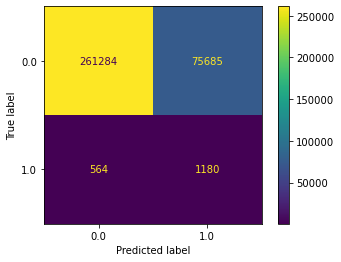

In [16]:
#Classifier confusion matrix
y_pred_log = logreg.predict(test_features)
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred_log)

### Kaggle Score

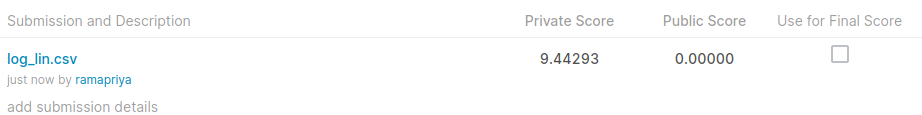

##  6.2 SGD Model

In [17]:
classifier = SGDClassifier(loss="log",alpha = 0.01, penalty="l2",class_weight='balanced',random_state=42)
regressor = SGDRegressor(loss='squared_loss',alpha=0.0001,penalty='l2')

In [18]:
%%time
classifier.fit(train_features, train_labels)

CPU times: user 17.6 s, sys: 3.03 s, total: 20.6 s
Wall time: 20.6 s


SGDClassifier(alpha=0.01, class_weight='balanced', loss='log', random_state=42)

In [19]:
regressor.fit(reg_features, reg_target)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:169: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  FutureWarning,


SGDRegressor(loss='squared_loss')

In [20]:
classifier_pred = classifier.predict_proba(test.drop(target_cols,axis=1))
regressor_pred = regressor.predict(test.drop(target_cols,axis=1))
final_pred = (classifier_pred[:,1]*regressor_pred)

In [21]:
#Submit file for kaggle
pred_df = sub_file(test,final_pred)
pred_df.to_csv('pred_linear_models1.csv',index=False)

In [22]:
regr_metric(test_df,pred_df)

rms = 3.876272438141856e+25
map = 9.739117418375224e+23


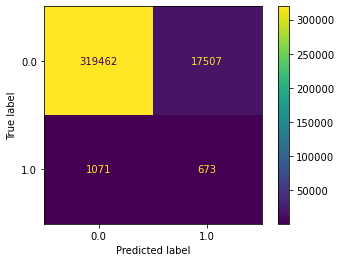

In [23]:
#https://scikit-learn.org/stable/modules/generated/
#sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions
#
#Classifier confusion matrix
y_pred_sgd = classifier.predict(test_features)
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred_sgd)

### Kaggle Score

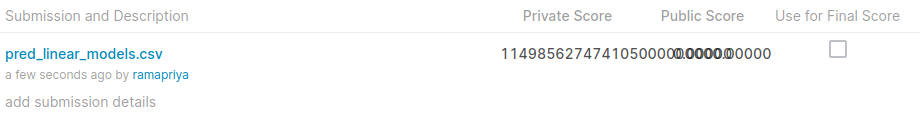

##  6.3 Random Forest Model

Most important hyperparameters of Random Forest:

- n_estimators = n of trees
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

source:
https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/random_forest_explained/Improving%20Random%20Forest%20Part%202.ipynb

### 6.3.1 RF Classifier

In [25]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 11, num = 11)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf 
                }

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier(random_state = 42)
#display default parameters
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [27]:
%%time
rfc_random = RandomizedSearchCV(estimator=rfc, param_distributions=random_grid,
                                cv =2, verbose=10, random_state=42,n_iter = 15, 
                                return_train_score=True)

rfc_random.fit(train_features, train_labels)

Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV 1/2; 1/15] START max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=900
[CV 1/2; 1/15] END max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=900;, score=(train=0.995, test=0.995) total time= 8.4min
[CV 2/2; 1/15] START max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=900
[CV 2/2; 1/15] END max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=900;, score=(train=0.995, test=0.995) total time= 8.8min
[CV 1/2; 2/15] START max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1100
[CV 1/2; 2/15] END max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1100;, score=(train=0.995, test=0.995) total time=15.1min
[CV 2/2; 2/15] START max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1100

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42),
                   n_iter=15,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, return_train_score=True, verbose=10)

In [28]:
rfc_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10}

In [29]:
rfc_random.best_score_

0.9948865263550867

In [10]:
RFclassifier = RandomForestClassifier(n_estimators= 1200,
                                    min_samples_split= 2,
                                    min_samples_leaf= 4,random_state=42,
                                    max_depth=10,max_features= 'sqrt',
                                    n_jobs=-1)

In [11]:
%%time
RFclassifier.fit(train_features, train_labels)

CPU times: user 1h 42min 4s, sys: 5.11 s, total: 1h 42min 9s
Wall time: 25min 42s


RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                       n_estimators=1200, n_jobs=-1, random_state=42)

### 6.3.2 RF Regressor

In [12]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 15)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 11, num = 11)]
# Minimum number of samples required to split a node
min_samples_split = [2,3,5,7,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': [True, False],
               'min_samples_leaf': min_samples_leaf 
                }

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'min_samples_split': [2, 3, 5, 7, 10], 'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4]}


In [13]:
rfr = RandomForestRegressor(random_state = 42)
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [14]:
rfr_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid,
                              n_iter =25, scoring='neg_root_mean_squared_error', 
                              cv = 2, verbose=10, random_state=42,  
                              return_train_score=True)

In [15]:
%%time
# Fit the random search model
rfr_random.fit(reg_features, reg_target)

Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV 1/2; 1/25] START bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1100
[CV 1/2; 1/25] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1100;, score=(train=-3.309, test=-4.911) total time= 1.7min
[CV 2/2; 1/25] START bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1100
[CV 2/2; 1/25] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1100;, score=(train=-3.870, test=-4.124) total time= 1.8min
[CV 1/2; 2/25] START bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600
[CV 1/2; 2/25] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=(train=-3.602, test=-4.634) total time=   1.8s
[CV 2/

RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
                   n_iter=25,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=10)

In [16]:
rfr_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 6,
 'bootstrap': True}

In [17]:
rfr_random.best_score_

-4.08660985336239

In [24]:
RFregressor = RandomForestRegressor(n_estimators= 400,
                                  min_samples_split=5,
                                  min_samples_leaf= 4,
                                  max_features='auto',
                                  max_depth=6,
                                  bootstrap= True,n_jobs=-1) 

In [25]:
RFregressor.fit(reg_features, reg_target)

RandomForestRegressor(max_depth=6, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=400, n_jobs=-1)

In [61]:
classifier_pred = RFclassifier.predict_proba(test.drop(target_cols,axis=1))
regressor_pred = RFregressor.predict(test.drop(target_cols,axis=1))
final_pred = (classifier_pred[:,1]*regressor_pred)

In [62]:
#Submit file for kaggle
pred_df = sub_file(test,final_pred)
pred_df.to_csv('pred_rf_models.csv',index=False)

In [22]:
regr_metric(test_df,pred_df)

rms = 2.1105717768256254
map = 0.25809990020729334


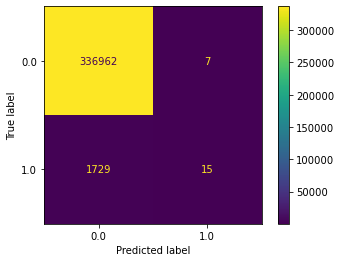

In [23]:
#https://scikit-learn.org/stable/modules/generated/
#sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions
#
#Classifier confusion matrix
y_pred_rf = RFclassifier.predict(test_features)
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred_rf)

### Kaggle Score

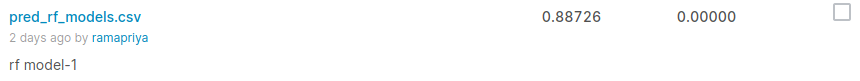

##  6.3 LightGBM  

Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

### 6.3.1 LBG classification model :

In [24]:
clf = lgb.LGBMClassifier()

#check default parameters
clf.get_params() 

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [25]:
gridParams = {
'learning_rate': [0.01,0.015,0.02,0.025,0.030,0.035,0.04,0.045,0.05], #Learning rate
'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1500, num = 15)],
'num_leaves': [3,5,7,9,11,13,15,17], #number of leaves in full tree
'boosting_type' : ['gbdt'],
'objective' : ['binary'], #Binary Classification model  
'metric' : ['binary_logloss','roc_auc'], #Performance metric 
'colsample_bytree' : [ 0.5,0.6,0.7,0.8, 1], #  select % of features before training each tree
'subsample' : [0.5,0.6,0.7,0.8,0.9], # select part of data without resampling
'reg_alpha' : [0,0.5,0.75,1], #L1 regularization
'reg_lambda' : [0,0.5,0.75,1], #L2 regularization
'max_leaves': [32,64,128,256], #Max  nodes  added.
'min_child_samples' : [1,2,3,4,5,7,8,9,10] #Min data points in child (leaf) node.
}

In [26]:
lbg_clf_grid = RandomizedSearchCV(estimator=clf, param_distributions=gridParams,
                              n_iter =40, 
                              cv = 2, verbose=10, random_state=42,  
                              return_train_score=True)

In [27]:
%%time 
lbg_clf_grid.fit(train_features, train_labels)

Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV 1/2; 1/40] START boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.04, max_leaves=128, metric=binary_logloss, min_child_samples=5, n_estimators=1100, num_leaves=17, objective=binary, reg_alpha=0.75, reg_lambda=0, subsample=0.9
[LightGBM] [Warning] num_leaves is set=17, max_leaves=128 will be ignored. Current value: num_leaves=17
[CV 1/2; 1/40] END boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.04, max_leaves=128, metric=binary_logloss, min_child_samples=5, n_estimators=1100, num_leaves=17, objective=binary, reg_alpha=0.75, reg_lambda=0, subsample=0.9;, score=(train=0.996, test=0.995) total time= 2.0min
[CV 2/2; 1/40] START boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.04, max_leaves=128, metric=binary_logloss, min_child_samples=5, n_estimators=1100, num_leaves=17, objective=binary, reg_alpha=0.75, reg_lambda=0, subsample=0.9
[LightGBM] [Warning] num_leaves is set=17, max_leaves=128 will be i

RandomizedSearchCV(cv=2, estimator=LGBMClassifier(), n_iter=40,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             1],
                                        'learning_rate': [0.01, 0.015, 0.02,
                                                          0.025, 0.03, 0.035,
                                                          0.04, 0.045, 0.05],
                                        'max_leaves': [32, 64, 128, 256],
                                        'metric': ['binary_logloss', 'roc_auc'],
                                        'min_child_samples': [1, 2, 3, 4, 5, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                            

In [28]:
lbg_clf_grid.best_params_

{'subsample': 0.7,
 'reg_lambda': 0.75,
 'reg_alpha': 0.75,
 'objective': 'binary',
 'num_leaves': 15,
 'n_estimators': 1500,
 'min_child_samples': 1,
 'metric': 'binary_logloss',
 'max_leaves': 64,
 'learning_rate': 0.015,
 'colsample_bytree': 0.7,
 'boosting_type': 'gbdt'}

In [29]:
lbg_clf_grid.best_score_

0.9948875104714485

In [30]:
lbg_clfparm = {
"objective" : "binary", #Binary Classification model to predict whether customer will return during test window
"metric" : "binary_logloss", #Performance metric as "Binary Logloss"
"max_leaves": 64, #Maximum number of nodes to be added.
"num_leaves" : 64, #number of leaves in full tree
"min_child_samples" : 1, #Minimum number of data points needed in a child (leaf) node.
"learning_rate" : 0.015, #Learning rate
"subsample" : 0.7, #this will randomly select part of data without resampling
"colsample_bytree" : 0.7, #LightGBM will select 80% of features before training each tree
"n_estimators" : 1500, #number of boosting iterations
"reg_alpha" : 0.75, #L1 regularization
"reg_lambda": 0.75, #L2 regularization
'random_state': 42,    
"boosting_type" : "gbdt"}

In [31]:
lbgclf = lgb.LGBMClassifier(**lbg_clfparm)
#lgbm_clf.set_params(**lbg_clfparm)                        
lbgclf.get_params() 

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.7,
 'importance_type': 'split',
 'learning_rate': 0.015,
 'max_depth': -1,
 'min_child_samples': 1,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 1500,
 'n_jobs': -1,
 'num_leaves': 64,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.75,
 'reg_lambda': 0.75,
 'silent': 'warn',
 'subsample': 0.7,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'binary_logloss',
 'max_leaves': 64}

In [32]:
%%time
lbgclf.fit(train_features, train_labels)

CPU times: user 20min 42s, sys: 3.32 s, total: 20min 45s
Wall time: 5min 21s


LGBMClassifier(colsample_bytree=0.7, learning_rate=0.015, max_leaves=64,
               metric='binary_logloss', min_child_samples=1, n_estimators=1500,
               num_leaves=64, objective='binary', random_state=42,
               reg_alpha=0.75, reg_lambda=0.75, subsample=0.7)

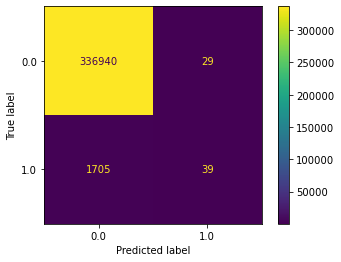

In [33]:
#https://scikit-learn.org/stable/modules/generated/
#sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions
#
#Classifier confusion matrix
y_pred_lbg1 = lbgclf.predict(test_features)
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred_lbg1)

## 6.3.1-b  RandomizedSearch fine tuning

We again perform RandomizedSearch around the best value obtained  with reduced search space to fine tune the hyperparameter values.

In [35]:
gridParams2 = {
'learning_rate': [0.011,0.013,0.015,0.017,0.019], #Learning rate
'n_estimators': [1450,1475,1500,1525,1550],
'num_leaves': [12,13,14,15,16,17], #number of leaves in full tree
'boosting_type' : ['gbdt'],
'objective' : ['binary'], #Binary Classification model  
'metric' : ['binary_logloss'], #Performance metric 
'colsample_bytree' : [0.65,0.68,0.70,0.73,0.75], #  select % of features before training each tree
'subsample' : [0.65,0.68,0.70,0.73,0.75], # select part of data without resampling
'reg_alpha' : [0.65,0.7,0.75,0.8,0.85], #L1 regularization
'reg_lambda' : [0.65,0.7,0.75,0.8,0.85], #L2 regularization
'max_leaves': [16,32,64,128,256], #Max  nodes  added.
'min_child_samples' : [1,2,3,4,5] #Min  data points in child (leaf) node.
}

In [36]:
lbg_clf_grid2 = RandomizedSearchCV(estimator=clf, param_distributions=gridParams2,
                              n_iter =20, 
                              cv = 2, verbose=10, random_state=42,  
                              return_train_score=True)

In [37]:
%%time 
lbg_clf_grid2.fit(train_features, train_labels)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV 1/2; 1/20] START boosting_type=gbdt, colsample_bytree=0.75, learning_rate=0.017, max_leaves=128, metric=binary_logloss, min_child_samples=2, n_estimators=1525, num_leaves=16, objective=binary, reg_alpha=0.85, reg_lambda=0.75, subsample=0.65
[LightGBM] [Warning] num_leaves is set=16, max_leaves=128 will be ignored. Current value: num_leaves=16
[CV 1/2; 1/20] END boosting_type=gbdt, colsample_bytree=0.75, learning_rate=0.017, max_leaves=128, metric=binary_logloss, min_child_samples=2, n_estimators=1525, num_leaves=16, objective=binary, reg_alpha=0.85, reg_lambda=0.75, subsample=0.65;, score=(train=0.995, test=0.995) total time= 2.7min
[CV 2/2; 1/20] START boosting_type=gbdt, colsample_bytree=0.75, learning_rate=0.017, max_leaves=128, metric=binary_logloss, min_child_samples=2, n_estimators=1525, num_leaves=16, objective=binary, reg_alpha=0.85, reg_lambda=0.75, subsample=0.65
[LightGBM] [Warning] num_leaves is set=16, max_le

RandomizedSearchCV(cv=2, estimator=LGBMClassifier(), n_iter=20,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.65, 0.68, 0.7,
                                                             0.73, 0.75],
                                        'learning_rate': [0.011, 0.013, 0.015,
                                                          0.017, 0.019],
                                        'max_leaves': [16, 32, 64, 128, 256],
                                        'metric': ['binary_logloss'],
                                        'min_child_samples': [1, 2, 3, 4, 5],
                                        'n_estimators': [1450, 1475, 1500, 1525,
                                                         1550],
                                        'num_leaves': [12, 13, 14, 15, 16, 17],
                                        'objective': ['binary'],
                                        'reg_alph

In [38]:
lbg_clf_grid2.best_params_

{'subsample': 0.75,
 'reg_lambda': 0.85,
 'reg_alpha': 0.65,
 'objective': 'binary',
 'num_leaves': 12,
 'n_estimators': 1475,
 'min_child_samples': 5,
 'metric': 'binary_logloss',
 'max_leaves': 32,
 'learning_rate': 0.013,
 'colsample_bytree': 0.75,
 'boosting_type': 'gbdt'}

In [39]:
lbg_clf_grid2.best_score_

0.9948904628321562

In [41]:
lbg_clfparm2 = {
"objective" : "binary", #Binary Classification model to predict whether customer will return during test window
"metric" : "binary_logloss", #Performance metric as "Binary Logloss"
"max_leaves": 32, #Maximum number of nodes to be added.
"num_leaves" : 12, #number of leaves in full tree
"min_child_samples" : 5, #Minimum number of data points needed in a child (leaf) node.
"learning_rate" : 0.13, #Learning rate
"subsample" : 0.75, #this will randomly select part of data without resampling
"colsample_bytree" : 0.75, #LightGBM will select 80% of features before training each tree
"n_estimators" : 1475, #number of boosting iterations
"reg_alpha" : 0.65, #L1 regularization
"reg_lambda": 0.85, #L2 regularization
"boosting_type" : "gbdt"}

lbgclf2 = lgb.LGBMClassifier(**lbg_clfparm2)
#lgbm_clf.set_params(**lbg_clfparm)                        
lbgclf2.get_params() 

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.75,
 'importance_type': 'split',
 'learning_rate': 0.13,
 'max_depth': -1,
 'min_child_samples': 5,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 1475,
 'n_jobs': -1,
 'num_leaves': 12,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.65,
 'reg_lambda': 0.85,
 'silent': 'warn',
 'subsample': 0.75,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'binary_logloss',
 'max_leaves': 32}

In [42]:
%%time
lbgclf2.fit(train_features, train_labels)

[LightGBM] [Warning] num_leaves is set=12, max_leaves=32 will be ignored. Current value: num_leaves=12
CPU times: user 15min 1s, sys: 5.88 s, total: 15min 7s
Wall time: 3min 58s


LGBMClassifier(colsample_bytree=0.75, learning_rate=0.13, max_leaves=32,
               metric='binary_logloss', min_child_samples=5, n_estimators=1475,
               num_leaves=12, objective='binary', reg_alpha=0.65,
               reg_lambda=0.85, subsample=0.75)

In [11]:
lbg_clfparm2 = {
"objective" : "binary", #Binary Classification model to predict whether customer will return during test window
"metric" : "binary_logloss", #Performance metric as "Binary Logloss"
"max_leaves": 32, #Maximum number of nodes to be added.
"num_leaves" : 2, #number of leaves in full tree
"min_child_samples" : 10, #Minimum number of data points needed in a child (leaf) node.
"learning_rate" : 0.1, #Learning rate
"subsample" : 0.7, #this will randomly select part of data without resampling
"colsample_bytree" : 0.6, #LightGBM will select 80% of features before training each tree
"bagging_frequency" : 1, #Perform bagging at every k iteration
"n_estimators" : 275, #number of boosting iterations
"reg_alpha" : 1, #L1 regularization
"reg_lambda": 0.75, #L2 regularization
"boosting_type" : "gbdt"}

In [12]:
lbgclf2 = lgb.LGBMClassifier(**lbg_clfparm2)

In [19]:
%%time
lbgclf2.fit(clf_features, clf_target)

CPU times: user 3min 57s, sys: 4.52 s, total: 4min 2s
Wall time: 1min 11s


LGBMClassifier(bagging_frequency=1, colsample_bytree=0.6, max_leaves=32,
               metric='binary_logloss', min_child_samples=10, n_estimators=275,
               num_leaves=2, objective='binary', reg_alpha=1, reg_lambda=0.75,
               subsample=0.7)

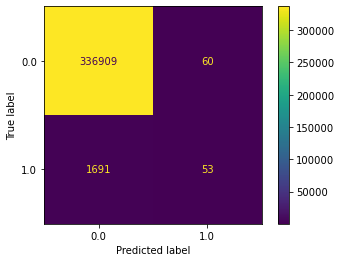

In [43]:
#https://scikit-learn.org/stable/modules/generated/
#sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions
#
#Classifier confusion matrix
y_pred_lbg2 = lbgclf2.predict(test_features)
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred_lbg2)

###  6.3.2 LBG regression model :

In [44]:
 gridParams_reg = {
'learning_rate': [ 0.01,0.02,0.025,0.03,0.04,0.05], #Learning rate
'n_estimators': [int(x) for x in np.linspace(start = 100, stop =2000, num = 15)],
'num_leaves': [ 2,3,5,7,9,11,13,15], #number of leaves in full tree
'boosting_type' : ['gbdt' ],
'objective' : ['regression'], #Regression model to predict transaction amount
'metric' : ['rmse'], #Performance metric as "RMSE
'colsample_bytree' : [0.2,0.4,0.6,0.8,0.9, 1], #  select features before training each tree
'subsample' : [0.5,0.6,0.7,0.8,0.9, 1], #   select part of data without resampling
'reg_alpha' : [0,0.5,1], #L1 regularization
'reg_lambda' : [0,0.5,1], #L2 regularization
'max_leaves': [32,64,128,256], #Max  nodes  added.
'min_child_samples' : [1,2,3,4,5,7,10,15,20] #Min data points in child (leaf) node.
}

In [47]:
# Define LightGBM Regressor model
lbgreg = lgb.LGBMRegressor()

lbg_reg_grid = RandomizedSearchCV(estimator=lbgreg, param_distributions=gridParams_reg,
                              n_iter =20, 
                              cv = 2, verbose=10, random_state=42,  
                              return_train_score=True)

In [48]:
%%time 
lbg_reg_grid.fit(reg_features, reg_target)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV 1/2; 1/20] START boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.03, max_leaves=128, metric=rmse, min_child_samples=2, n_estimators=507, num_leaves=15, objective=regression, reg_alpha=0.5, reg_lambda=1, subsample=0.9
[CV 1/2; 1/20] END boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.03, max_leaves=128, metric=rmse, min_child_samples=2, n_estimators=507, num_leaves=15, objective=regression, reg_alpha=0.5, reg_lambda=1, subsample=0.9;, score=(train=0.824, test=0.058) total time=   1.4s
[CV 2/2; 1/20] START boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.03, max_leaves=128, metric=rmse, min_child_samples=2, n_estimators=507, num_leaves=15, objective=regression, reg_alpha=0.5, reg_lambda=1, subsample=0.9
[LightGBM] [Warning] num_leaves is set=15, max_leaves=128 will be ignored. Current value: num_leaves=15
[CV 2/2; 1/20] END boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.03, max_leaves

RandomizedSearchCV(cv=2, estimator=LGBMRegressor(), n_iter=20,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.2, 0.4, 0.6, 0.8,
                                                             0.9, 1],
                                        'learning_rate': [0.01, 0.02, 0.025,
                                                          0.03, 0.04, 0.05],
                                        'max_leaves': [32, 64, 128, 256],
                                        'metric': ['rmse'],
                                        'min_child_samples': [1, 2, 3, 4, 5, 7,
                                                              10, 15, 20],
                                        'n_estimators': [100, 235, 371, 507,
                                                         642, 778, 914, 1050,
                                                         1185, 1321, 1457, 1592,
                                        

In [49]:
lbg_reg_grid.best_params_

{'subsample': 1,
 'reg_lambda': 1,
 'reg_alpha': 0.5,
 'objective': 'regression',
 'num_leaves': 7,
 'n_estimators': 235,
 'min_child_samples': 7,
 'metric': 'rmse',
 'max_leaves': 64,
 'learning_rate': 0.02,
 'colsample_bytree': 0.8,
 'boosting_type': 'gbdt'}

In [50]:
lbg_reg_grid.best_score_ 

0.03803305143915936

In [16]:
lbg_regparm = {
"objective" : "regression", #Regression model to predict transaction amount
"metric" : "rmse", #Performance metric as "RMSE"
"max_leaves": 64, #Maximum number of nodes to be added.
"num_leaves" : 7, #number of leaves in full tree
"min_child_samples" : 7, #Minimum number of data points needed in a child (leaf) node.
"learning_rate" : 0.02, #Learning rate
"subsample" : 1, #this will randomly select part of data without resampling
"colsample_bytree" : 0.8, #LightGBM will select 80% of features before training each tree
"n_estimators" :235, #number of boosting iterations
"reg_alpha" : 0.5, #L1 regularization
"reg_lambda": 1 , #L2 regularization
"boosting_type" : "gbdt"}

In [17]:
lbgreg= lgb.LGBMRegressor(**lbg_regparm)
lbgreg.fit(reg_features, reg_target)

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.02, max_leaves=64,
              metric='rmse', min_child_samples=7, n_estimators=235,
              num_leaves=7, objective='regression', reg_alpha=0.5, reg_lambda=1,
              subsample=1)

In [20]:
classifier_pred = lbgclf2.predict_proba(test.drop(target_cols,axis=1))
regressor_pred = lbgreg.predict(test.drop(target_cols,axis=1))
final_pred = (classifier_pred[:,1]*regressor_pred)

In [21]:
pred_df = pd.DataFrame({"fullVisitorId":test["fullVisitorId"].values})
pred_df["PredictedLogRevenue"] = final_pred
pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
pred_df.to_csv("pred_lbg_models.csv", index=False)

In [63]:
regr_metric(test_df,pred_df)

rms = 2.1098107659277883
map = 0.26371229802130824


### Kaggle Score
The LBGM model kaggle score is 0.88457 which is 21st place in public leaderboard.

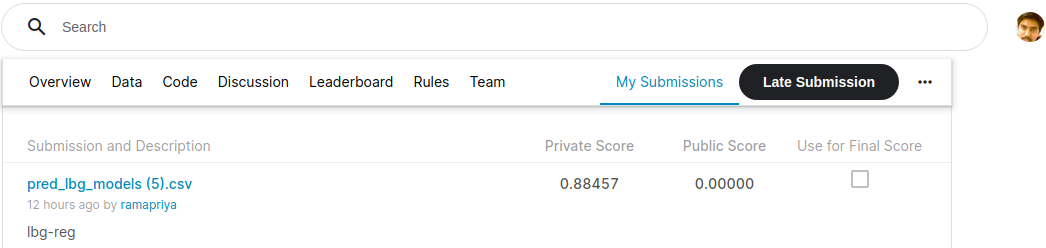

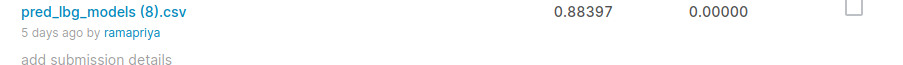

###  6.3.3 LGBMRegressor Feature Importance :

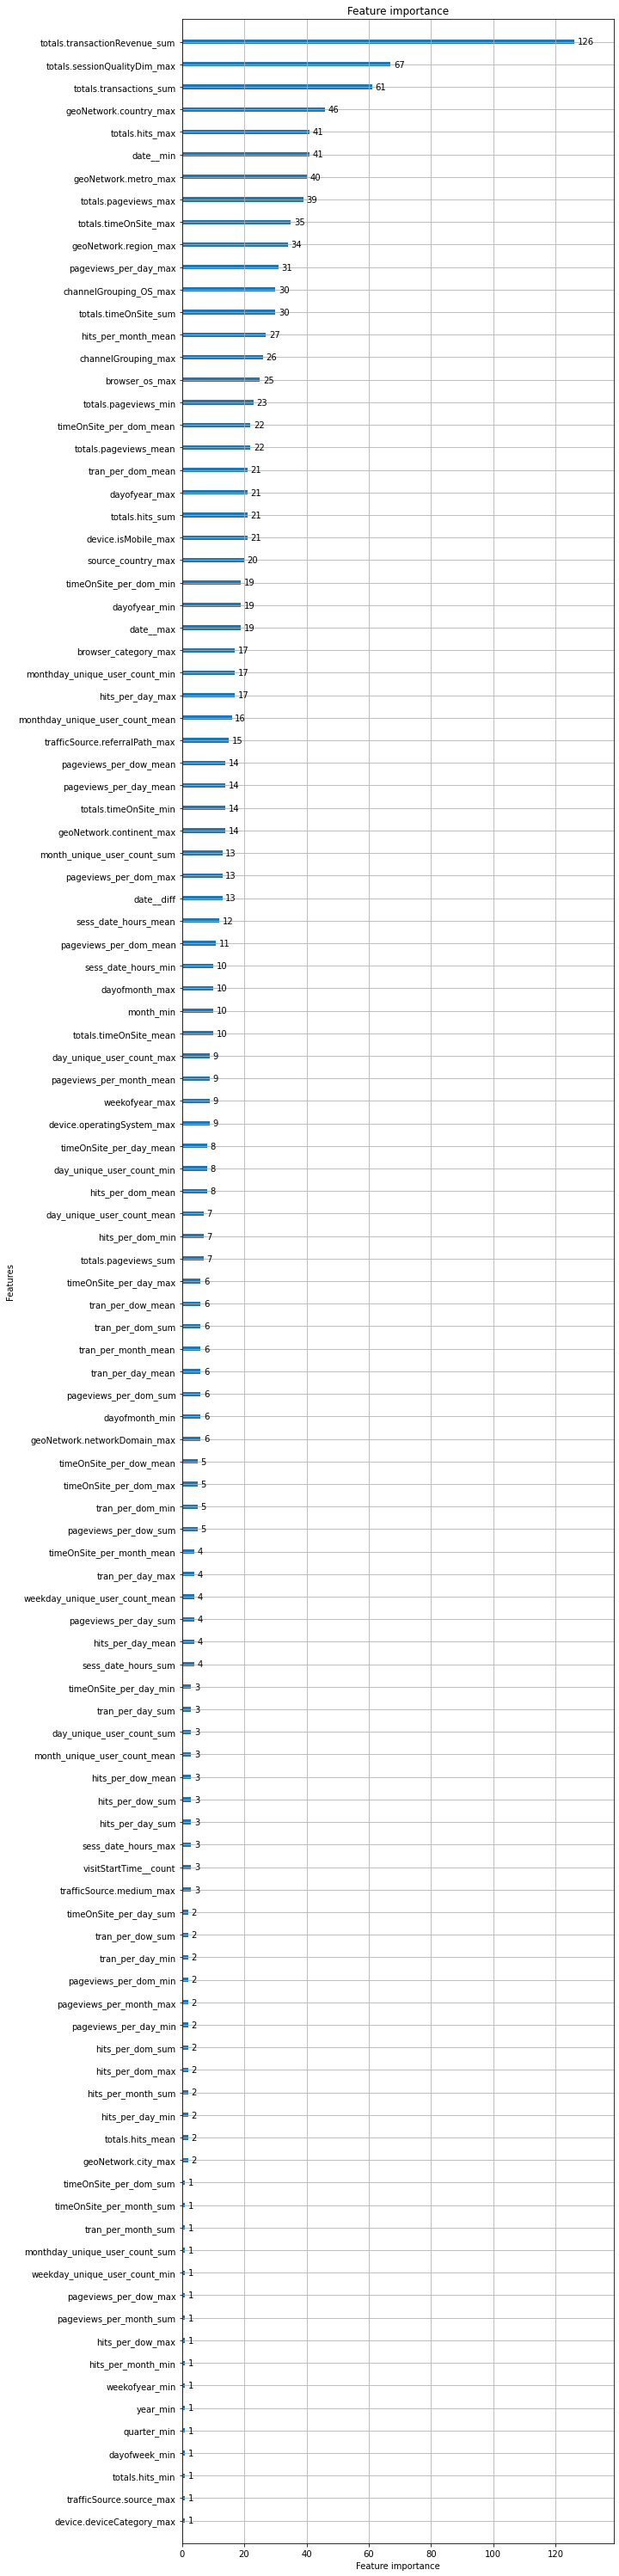

In [13]:
ax=lgb.plot_importance(lbgreg)
ax.figure.set_size_inches(9,54)

The top 5 features for regression are:  
1- totals.transactionRevenue_sum  
2- totals.sessionQualityDim_max  
3- geoNetwork.country_max  
4- totals.hits_max  
5- date_min

##  6.5 DecisionTree model

In [12]:
dt_clf=DecisionTreeClassifier()
dt_clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [13]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [ None,1,2,3,4,5,7,10],
              "max_features": randint(1, 130),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

In [14]:
dt_clf_grid = RandomizedSearchCV(estimator=dt_clf, param_distributions=param_dist,
                              n_iter =50, 
                              cv = 2, verbose=10, random_state=42,  
                              return_train_score=True)

In [15]:
%%time 
dt_clf_grid.fit(train_features, train_labels)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV 1/2; 1/50] START criterion=gini, max_depth=3, max_features=93, min_samples_leaf=7
[CV 1/2; 1/50] END criterion=gini, max_depth=3, max_features=93, min_samples_leaf=7;, score=(train=0.995, test=0.995) total time=  14.2s
[CV 2/2; 1/50] START criterion=gini, max_depth=3, max_features=93, min_samples_leaf=7
[CV 2/2; 1/50] END criterion=gini, max_depth=3, max_features=93, min_samples_leaf=7;, score=(train=0.995, test=0.995) total time=  13.9s
[CV 1/2; 2/50] START criterion=gini, max_depth=10, max_features=21, min_samples_leaf=7
[CV 1/2; 2/50] END criterion=gini, max_depth=10, max_features=21, min_samples_leaf=7;, score=(train=0.995, test=0.995) total time=  12.6s
[CV 2/2; 2/50] START criterion=gini, max_depth=10, max_features=21, min_samples_leaf=7
[CV 2/2; 2/50] END criterion=gini, max_depth=10, max_features=21, min_samples_leaf=7;, score=(train=0.995, test=0.995) total time=  12.7s
[CV 1/2; 3/50] START criterion=entropy, ma

RandomizedSearchCV(cv=2, estimator=DecisionTreeClassifier(), n_iter=50,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 1, 2, 3, 4, 5, 7,
                                                      10],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe918aaae50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe918aaaa90>},
                   random_state=42, return_train_score=True, verbose=10)

In [17]:
dt_clf_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 14,
 'min_samples_leaf': 7}

In [18]:
dt_clf_grid.best_score_

0.9948658599018015

In [22]:
df_clfparm = {
"criterion" : "entropy", 
"max_depth" : 5,
"max_features": 14,  
"min_samples_leaf" : 7 
 }

dt_clf = DecisionTreeClassifier(**df_clfparm)

In [23]:
%%time
dt_clf.fit(train_features, train_labels)

CPU times: user 9.74 s, sys: 5.69 s, total: 15.4 s
Wall time: 15.4 s


DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=14,
                       min_samples_leaf=7)

In [24]:
# Predicting probility on test data
dtc_pred = dt_clf.predict_proba(test.drop(target_cols,axis=1))

##  6.5.2  DecisionTreeRegressor  

In [26]:
# Setup the parameters and distributions to sample from: param_dist
df_regparm = {"max_depth": [ None,1,2,3,4,5,7,10],
              "max_features": randint(1, 130),
              "min_samples_leaf": randint(1, 9),
               }

In [27]:
dt_reg= DecisionTreeRegressor()

In [28]:
dt_reg_grid = RandomizedSearchCV(estimator=dt_reg, param_distributions=df_regparm,
                              n_iter =50, 
                              cv = 2, verbose=10, random_state=42,  
                              return_train_score=True)

In [29]:
%%time 
dt_reg_grid.fit(reg_features, reg_target)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV 1/2; 1/50] START max_depth=7, max_features=93, min_samples_leaf=7...........
[CV 1/2; 1/50] END max_depth=7, max_features=93, min_samples_leaf=7;, score=(train=0.257, test=0.064) total time=   0.1s
[CV 2/2; 1/50] START max_depth=7, max_features=93, min_samples_leaf=7...........
[CV 2/2; 1/50] END max_depth=7, max_features=93, min_samples_leaf=7;, score=(train=0.351, test=-0.312) total time=   0.1s
[CV 1/2; 2/50] START max_depth=2, max_features=72, min_samples_leaf=5...........
[CV 1/2; 2/50] END max_depth=2, max_features=72, min_samples_leaf=5;, score=(train=0.059, test=0.097) total time=   0.1s
[CV 2/2; 2/50] START max_depth=2, max_features=72, min_samples_leaf=5...........
[CV 2/2; 2/50] END max_depth=2, max_features=72, min_samples_leaf=5;, score=(train=0.152, test=-0.034) total time=   0.1s
[CV 1/2; 3/50] START max_depth=4, max_features=103, min_samples_leaf=2..........
[CV 1/2; 3/50] END max_depth=4, max_features=10

RandomizedSearchCV(cv=2, estimator=DecisionTreeRegressor(), n_iter=50,
                   param_distributions={'max_depth': [None, 1, 2, 3, 4, 5, 7,
                                                      10],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe692a40890>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe692a40910>},
                   random_state=42, return_train_score=True, verbose=10)

In [30]:
dt_reg_grid.best_params_

{'max_depth': 2, 'max_features': 63, 'min_samples_leaf': 8}

In [ ]:
dt_reg_grid.best_score_

In [31]:
dtParams_reg = {
"max_depth" : 2,
"max_features": 63,  
"min_samples_leaf" : 8 
 }

dt_regr= DecisionTreeRegressor(**dtParams_reg) 

In [32]:
dt_regr.fit(reg_features, reg_target)

DecisionTreeRegressor(max_depth=2, max_features=63, min_samples_leaf=8)

In [33]:
reg_pred = dt_regr.predict(test.drop(target_cols,axis=1))
final_pred= dtc_pred[:,1]*reg_pred

In [34]:
#Submit file for kaggle
pred = sub_file(test,final_pred)
pred.to_csv('pred_dt.csv',index=False)

In [35]:
regr_metric(test_df,pred)

rms = 2.12490059592348
map = 0.2560918274186593


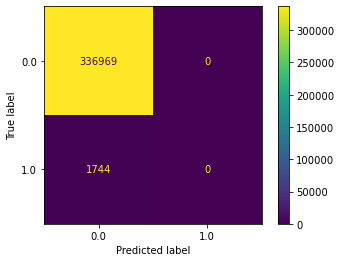

In [36]:
#https://scikit-learn.org/stable/modules/generated/
#sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions
#
#Classifier confusion matrix
y_pred_dt = dt_clf.predict(test_features)
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred_dt)

##  6.6  Support Vector Regression

In [12]:
svr_reg = SVR() 

In [13]:
svr_regparm =  {
'C': [1, 10, 100, 1000],
'gamma': [0.001, 0.0001]
}

In [14]:
svr_reg_grid = RandomizedSearchCV(estimator=svr_reg, param_distributions=svr_regparm,
                              n_iter =8, 
                              cv = 2, verbose=10, random_state=42,  
                              return_train_score=True)

In [15]:
%%time 
svr_reg_grid.fit(reg_features, reg_target)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2; 1/8] START C=1, gamma=0.001............................................
[CV 1/2; 1/8] END C=1, gamma=0.001;, score=(train=0.081, test=-0.059) total time=   4.0s
[CV 2/2; 1/8] START C=1, gamma=0.001............................................
[CV 2/2; 1/8] END C=1, gamma=0.001;, score=(train=0.057, test=-0.027) total time=   3.6s
[CV 1/2; 2/8] START C=1, gamma=0.0001...........................................
[CV 1/2; 2/8] END C=1, gamma=0.0001;, score=(train=0.079, test=-0.059) total time=   3.6s
[CV 2/2; 2/8] START C=1, gamma=0.0001...........................................
[CV 2/2; 2/8] END C=1, gamma=0.0001;, score=(train=0.056, test=-0.027) total time=   3.9s
[CV 1/2; 3/8] START C=10, gamma=0.001...........................................
[CV 1/2; 3/8] END C=10, gamma=0.001;, score=(train=0.813, test=-0.025) total time=   3.9s
[CV 2/2; 3/8] START C=10, gamma=0.001...........................................
[CV 2/

RandomizedSearchCV(cv=2, estimator=SVR(), n_iter=8,
                   param_distributions={'C': [1, 10, 100, 1000],
                                        'gamma': [0.001, 0.0001]},
                   random_state=42, return_train_score=True, verbose=10)

In [16]:
svr_reg_grid.best_params_

{'gamma': 0.001, 'C': 10}

In [17]:
svr_reg_grid.best_score_

-0.012501533004874

In [18]:
svrParams_reg = {
"gamma" : 0.001,
"C": 10 
 }

svm_regr= SVR(**svrParams_reg)

In [19]:
svm_regr.fit(reg_features, reg_target)

SVR(C=10, gamma=0.001)

In [20]:
reg_pred = svm_regr.predict(test.drop(target_cols,axis=1))

In [25]:
final_pred= dtc_pred[:,1]*reg_pred

In [26]:
#Submit file for kaggle
pred_svr = sub_file(test,final_pred)
pred_svr.to_csv('pred_svr.csv',index=False)

In [27]:
regr_metric(test_df,pred_svr)

rms = 2.1116832690285428
map = 0.2960259931515362


##  6.6 Model Scores

#### Logistic + Linear regression 

rms = 9.24998382706949   
map = 8.891554903710544   
kaggle= 9.44293       

#### SGD Model(SGDClassifier,SGDRegressor)

Rms =  3.876272438141856e+25  
map = 9.739117418375224e+23  
kaggle= 1114008574477370000000000    

#### Random Forest Model(RandomForestRegressor,RandomForestClassifier)   
rms = 2.1105717768256254   
map = 0.25809990020729334      
kaggle= 0.88726      

#### DecisionTreeClassifier,DecisionTreeRegressor   
rms = 2.12490059592348     
map = 0.2560918274186593   
kaggle= 0.88771     

#### Support Vector Regression,DT-Classifier    
rms = 2.1116832690285428  
map = 0.2960259931515362   
kaggle=  0.8896   

#### LightGBM (LGBMClassifier,LGBMRegressor)
rms = 2.1098107659277883  
map = 0.2637122980213082     
kaggle= 0.88457  (21st position)   
kaggle(2nd-best)= 0.88437 (17th position)   
kaggle(best)= 0.88397 (14th position)      

The results shows  that linear models perform is not good.   
LightGBM is the fastest  and best model.